In [46]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [8]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 4

trainset = tv.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = t.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
testset = tv.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = t.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


  car  bird  frog  bird


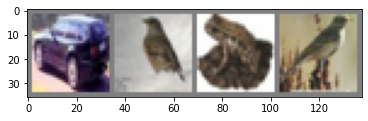

In [44]:
def imgshow(img):
    npimg = (img/2 + 0.5).numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.show

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(tv.utils.make_grid(images))
print(' '.join('%5s' % classes [labels[j]] for j in range(batch_size)))

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [48]:
crit = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

  cat   cat   cat   cat


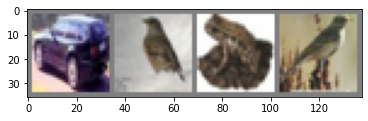

In [67]:
out = net(images)

_, idx = out.max(1)

imgshow(tv.utils.make_grid(images))
print(' '.join('%5s' % classes [idx[j]] for j in range(batch_size)))

loss = crit(out, labels)


[1,  2000] loss: 2.239
 deer plane   car  deer
[1,  4000] loss: 1.896
 frog   car   car   car
[1,  6000] loss: 1.723
truck  ship horse   dog
[1,  8000] loss: 1.589
  cat   car  frog   car
[1, 10000] loss: 1.499
  car horse horse truck
[1, 12000] loss: 1.451
  dog  deer truck horse
[2,  2000] loss: 1.347
  dog truck   car  ship
[2,  4000] loss: 1.346
horse   dog  bird  deer
[2,  6000] loss: 1.313
  dog horse   dog horse
[2,  8000] loss: 1.291
  cat  ship   dog plane
[2, 10000] loss: 1.265
  cat  ship horse   cat
[2, 12000] loss: 1.261
  dog   dog  ship   car
Finished Training


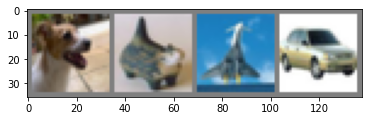

In [71]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        opt.zero_grad()
        out = net(inputs)
        
        loss = crit(out, labels)
        loss.backward() 
        
        opt.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

In [73]:
PATH = './cifar_net.pth'
t.save(net.state_dict(), PATH)

Groundtruth: frog   dog plane  frog
Prediction: frog  frog plane  frog


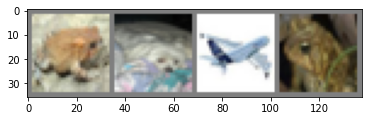

In [74]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(tv.utils.make_grid(images))
print('Groundtruth:'+' '.join('%5s' % classes [labels[j]] for j in range(batch_size)))

net.load_state_dict(t.load(PATH))

out = net(images)

_, idx = out.max(1)

print('Prediction:'+' '.join('%5s' % classes [idx[j]] for j in range(batch_size)))